# Relaxometry: Measurement of Spin Relaxation Times $T_1$ and $T_2$

## Imports 

In [49]:
import os
import cupy as cp 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io as sio 
from scipy.optimize import minimize
from tqdm import tqdm

## Extended Phase Graph Simulation Functions 

In [42]:
def rf(om, alpha, phi):
    halpha = 0.5*alpha
    T = cp.zeros((3,3), dtype=cp.complex64)
    T[0,0] = np.cos(halpha)*np.cos(halpha)
    T[0,1] = np.sin(halpha)*np.sin(halpha)*np.cos(2.0*phi) + 1j*np.sin(halpha)*np.sin(halpha)*np.sin(2*phi)
    T[0,2] = np.sin(alpha)*np.sin(phi) - 1j*np.sin(alpha)*np.cos(phi)
    T[1,0] = np.sin(halpha)*np.sin(halpha)*np.cos(2.0*phi) - 1j*np.sin(halpha)*np.sin(halpha)*np.sin(2.0*phi)
    T[1,1] = np.cos(halpha)*np.cos(halpha)
    T[1,2] = np.sin(alpha)*np.sin(phi) + 1j*np.sin(alpha)*np.cos(phi)
    T[2,0] = -0.5*np.sin(alpha)*np.sin(phi) - 1j*0.5*np.sin(alpha)*np.cos(phi)
    T[2,1] = -0.5*np.sin(alpha)*np.sin(phi) + 1j*0.5*np.sin(alpha)*np.cos(phi)
    T[2,2] = np.cos(alpha)
    return T@om 

def relax(om, T1, T2, dt):
    E1 = cp.exp(-dt/T1)
    E2 = cp.exp(-dt/T2)[:,None,None]
    om[:,:2,:] = om[:,:2,:] * E2 
    om[:,2,:] = om[:,2,:] * E1[:,None]
    om[:,2,0] = om[:,2,0] + 1.0 - E1 
    return om 

def spoil(om):
    om[:,0,:] = cp.roll(om[:,0,:], 1, axis=-1)
    om[:,1,:] = cp.roll(om[:,1,:],-1, axis=-1)
    om[:,1,-1] = 0.0 
    om[:,0,0] = cp.conj(om[:,1,0])
    return om 

def sample(om, phi): 
    return om[:,0,0] * np.exp(-1j*phi)

def equilibriumMagnetization(ntissues, nstates): 
    om = cp.zeros((ntissues, 3, nstates), dtype=cp.complex64) 
    om[:,2,0] = 1.0 
    return om 

def gre_epg(alpha, phi, te, tr, T1, T2, IR=False, om=None):
    om = equilibriumMagnetization(T1.size, alpha.size+1)
    if IR:
        om[:,2,0] = -1.0
    sig = cp.zeros((T1.size, alpha.size), dtype=cp.complex64)
    for n in range(alpha.size): 
        om[:,:,:(n+1)] = rf(om[:,:,:(n+1)], alpha[n], phi[n])
        om = relax(om, T1, T2, te[n])
        sig[:,n] = sample(om, phi[n])
        om = relax(om, T1, T2, tr[n]-te[n])
        om = spoil(om)
    return sig 

## Basic SPGR

SPGR: Spoiled Gradient Recalled Echo 

In SPGR (or "FLASH" or "TFE"), we apply a train of RF pulses with very short repetition times (e.g., 5 ms). Within each TR we
1. acquire data at the echo time 
2. apply a gradient pulse to dephase signal within each voxel
3. increment the phase of the next RF pulse to approximate a perfectly spoiled pulse sequence

When spoiling is perfect (i.e., when no transverse magnetization exists before the beginning of each RF pulse), the signal can be approximated by

$S = \frac{M_0(1 - E_1)\sin(\alpha)}{1 - E_1\cos(\alpha)}$,
where $E_1 = e^{-TR/T_1}$

In the simulation below, we will see how well this approximation holds.

### RF Spoiling

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [03:26<00:00,  1.15s/it]


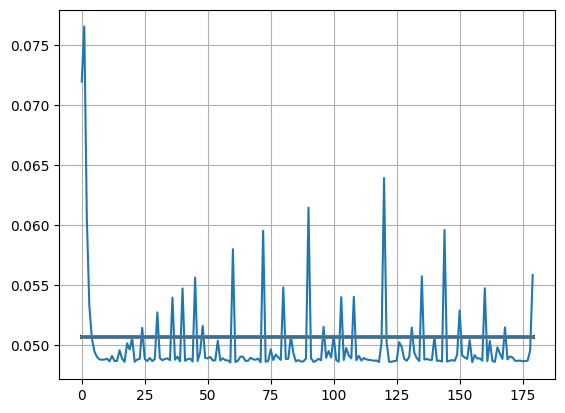

In [43]:

# set T1 and T2 relaxation times [seconds]
t1val = 0.8
t2val = 0.08
T1 = cp.array([t1val], dtype=cp.float32) 
T2 = cp.array([t2val], dtype=cp.float32) 

flipAngle = 10.0 # [degrees]
TR = 0.005       # [seconds]
TE = 0.002       # [seconds]
npulses = 1000

# make arrays from input above 
alpha = flipAngle * np.pi / 180 * np.ones((npulses,), dtype=np.float32)
tr = TR * np.ones_like(alpha) 
te = TE * np.ones_like(alpha) 

# array of RF phase quadratic spoiling increments 
rfSpoilingIncrement = np.arange(0,180,dtype=np.float32) 

signal = np.zeros((rfSpoilingIncrement.size,), dtype=np.complex64)
for n in tqdm(range(rfSpoilingIncrement.size)): 
    phi = 0.5 * (rfSpoilingIncrement[n] * np.pi / 180) * (np.arange(0,npulses)**2 + np.arange(0,npulses) + 2)
    mxy = cp.asnumpy( gre_epg(alpha, phi, te, tr, T1, T2) )
    signal[n] = mxy[0,-1]

# analytical SPGR signal for reference 
sig_spgr = np.sin(alpha) * (1 - np.exp(-TR/t1val) ) / (1 - np.cos(alpha)*np.exp(-TR/t1val) )

plt.figure() 
plt.plot(rfSpoilingIncrement, np.abs(signal))
plt.plot([rfSpoilingIncrement[0], rfSpoilingIncrement[-1]], [sig_spgr, sig_spgr])
plt.grid()
plt.show() 


### Quantifying $T_1$ with SPGR

After some some rearranging and substitutions, the SPGR signal can be expressed as below. 

$\frac{S}{\sin(\alpha)} = E_1\frac{S}{\tan(\alpha)} + M_0(1 - E_1)$

This is of the form $y = mx + b$, and we can can fit a line to measurements made at several flip angles. The slope of this line is $E_1$ with $T_1 = \frac{-TR}{\ln E_1}$.

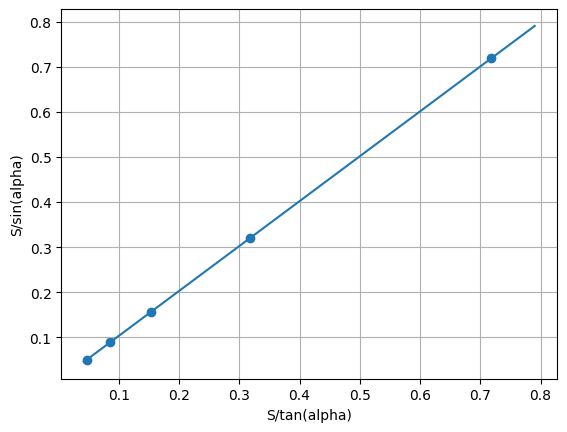

Actual T1: 1.400000
Estimated T1: 1.597219


In [61]:
# set T1 and T2 relaxation times [seconds]
t1val = 1.4
t2val = 0.1
T1 = cp.array([t1val], dtype=cp.float32) 
T2 = cp.array([t2val], dtype=cp.float32) 


flipAngles = np.array([3.0, 7.0, 11.0, 15.0, 20.0], dtype=np.float32)
phi = 0.5 * (117.0 * np.pi / 180) * (np.arange(0,npulses)**2 + np.arange(0,npulses) + 2)

signal = np.zeros((flipAngles.size,), dtype=np.complex64)
for n in range(flipAngles.size): 
    alpha = flipAngles[n]*np.pi/180 * np.ones_like(phi)
    mxy = cp.asnumpy( gre_epg(alpha, phi, te, tr, T1, T2) )
    signal[n] = mxy[0,-1]

noise_level = 1e-4
noise = noise_level * (np.random.randn(signal.size) + 1j*np.random.randn(signal.size))
noisy_signal = signal + noise 


salpha = np.sin(flipAngles*np.pi/180) 
talpha = np.tan(flipAngles*np.pi/180) 

X = np.abs(noisy_signal)/talpha 
Y = np.abs(noisy_signal)/salpha 

# fit a line to the data 
A = np.stack([X, np.ones_like(X)], axis=-1)
beta = np.linalg.inv(A.T@A)@(A.T@Y)
slope = beta[0]
intercept = beta[1]
xplot = np.linspace(np.min(X)*0.9, np.max(X)*1.1, 100)
yplot = xplot * slope + intercept

plt.figure()
plt.scatter(X,Y)
plt.plot(xplot, yplot)
plt.xlabel('S/tan(alpha)')
plt.ylabel('S/sin(alpha)')
plt.grid()
plt.show()

T1_hat = -TR / np.log(slope) 
print('Actual T1: %f'%(t1val))
print('Estimated T1: %f'%(T1_hat))

From above, we can see that RF spoiling is not perfectly sufficient because $T_2$ being much longer than the TR. So, how can we improve $T_1$ mapping in the presence of realistic $T_2$ and spoiling conditions? 

### Inversion Recovery SPGR

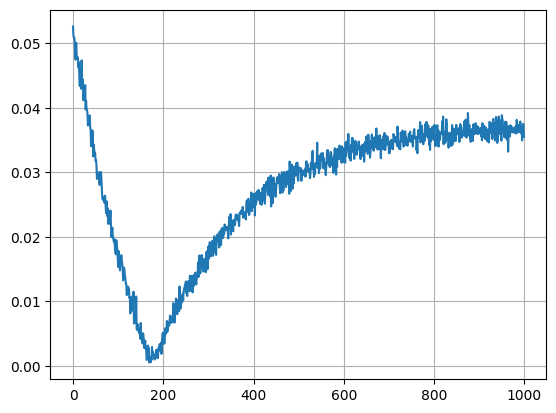

In [62]:
# set T1 and T2 relaxation times [seconds]
t1val = 1.4
t2val = 0.1
T1 = cp.array([t1val], dtype=cp.float32) 
T2 = cp.array([t2val], dtype=cp.float32) 


alpha = 3.0 * np.pi / 180 * np.ones((npulses,), dtype=np.float32)
phi = 0.5 * (117.0 * np.pi / 180) * (np.arange(0,npulses)**2 + np.arange(0,npulses) + 2)
tr = 0.005 * np.ones_like(alpha) 
te = 0.001 * np.ones_like(alpha) 

signal = cp.asnumpy( gre_epg(alpha, phi, te, tr, T1, T2, IR=True) )[0,:]

noise_level = 1e-3
noise = noise_level * (np.random.randn(signal.size) + 1j*np.random.randn(signal.size))
noisy_signal = signal + noise 

plt.figure()
plt.plot(np.abs(noisy_signal))
plt.grid()
plt.show()


True T1: 1.400000
Estimated T1: 1.397457


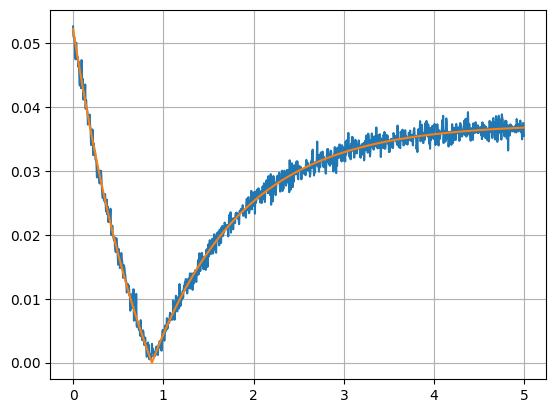

In [63]:

# fit T1 to the noisy curve
t = np.arange(0,npulses,dtype=np.float32) * tr[0]
model = lambda x: np.abs(x[0] - x[1]*np.exp(-t/x[2]))
cost = lambda x: np.sum((model(x) - np.abs(noisy_signal))**2)
x0 = np.array([np.abs(noisy_signal)[-1], 2.0*np.abs(noisy_signal)[-1], 1.0])
xopt = minimize(cost, x0).x
A = xopt[0]
B = xopt[1]
T1app = xopt[2]
T1_hat = T1app*(B/A - 1.0)

print('True T1: %f'%(t1val)) 
print('Estimated T1: %f'%(T1_hat)) 

fit = model(xopt) 
plt.figure() 
plt.plot(t, np.abs(noisy_signal))
plt.plot(t, fit)
plt.grid()
plt.show()

Despite $T_2$ being significantly long here, this method is able to accurately quantify $T_1$ under non-ideal spoiling conditions. 

What are the drawbacks? 

1. A low flip angle is required, leading to poor SNR
2. Scan times add up with only a handfull of k-space lines being acquired per inverision pulse

### MRF: Inversion-Recovery GRE with a Twist

To get around the limitations of IR-SPGR for $T_1$ mapping, we will change the flip angle of the excitation pulse immediately following an inversion pulse. This leads to high SNR and affords the possibility to minimize the amount of data sampled in each frame. 

Below, we make a flip angle pattern: 

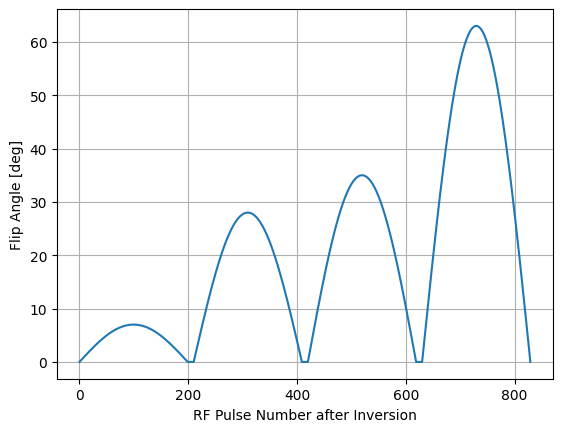

In [64]:

base = np.sin(np.linspace(0,np.pi,200))
z = np.zeros((10,), dtype=np.float32)
alpha = 70*np.pi/180 * np.concatenate([0.1*base, z, 0.4*base, z, 0.5*base, z, 0.9*base])

plt.figure()
plt.plot(alpha*180/np.pi)
plt.xlabel('RF Pulse Number after Inversion')
plt.ylabel('Flip Angle [deg]')
plt.grid()
plt.show()

### Simulating Responses to the Flip Angle Train (Referred to as "Fingerprints")

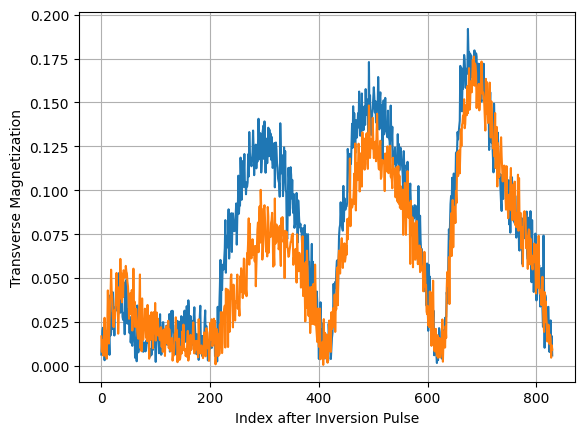

In [72]:
# set T1 and T2 relaxation times [seconds]
T1 = cp.array([0.7,  1.2], dtype=cp.float32) 
T2 = cp.array([0.07, 0.1], dtype=cp.float32) 

phi = np.zeros_like(alpha) 
tr = 0.005 * np.ones_like(alpha) 
te = 0.001 * np.ones_like(alpha) 

signal = cp.asnumpy( gre_epg(alpha, phi, te, tr, T1, T2, IR=True) )

# let's make them really noisy to show power of MRF 
noise_level = 1e-2
noise = noise_level * (np.random.randn(signal.shape[0], signal.shape[1]) + 1j*np.random.randn(signal.shape[0], signal.shape[1]))
noisy_signal = signal + noise 

plt.figure()
plt.plot(np.abs(noisy_signal.T))
plt.grid()
plt.ylabel('Transverse Magnetization')
plt.xlabel('Index after Inversion Pulse')
plt.show() 

### Simulating a Dictionary of MR Fingerprints 

In [82]:
inc = 1.03
T1min = 0.25
T1max = 3.0
T1vals = [T1min]
while T1vals[-1] < T1max: 
    T1vals.append(T1vals[-1]*inc)
T1vals = np.array(T1vals)
T2min = 0.02
T2max = 2.0
T2vals = [T2min]
while T2vals[-1] < T2max: 
    T2vals.append(T2vals[-1]*inc)
T2vals = np.array(T2vals) 

T1dict = np.zeros((T1vals.size*T2vals.size,), dtype=np.float32)
T2dict = np.zeros((T1vals.size*T2vals.size,), dtype=np.float32)
for n1 in range(T1vals.size): 
    for n2 in range(T2vals.size):
        n = n1*T2vals.size + n2 
        T1dict[n] = T1vals[n1]
        T2dict[n] = T2vals[n2]

T1 = cp.asarray(T1dict)
T2 = cp.asarray(T2dict) 

signal = cp.asnumpy( gre_epg(alpha, phi, te, tr, T1, T2, IR=True) )


### Dictionary Matching to Estimate $T_1$ and $T_2$

0.70346564
0.06921392
1.2335312
0.09580825


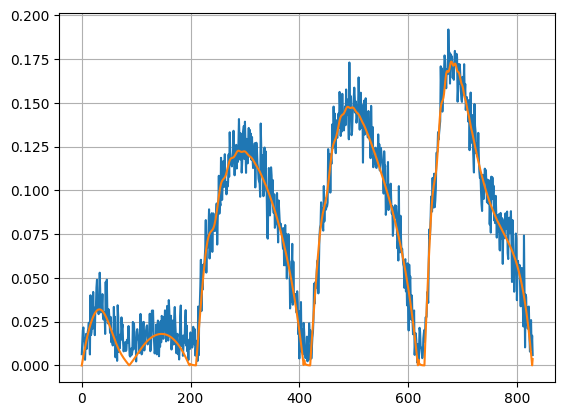

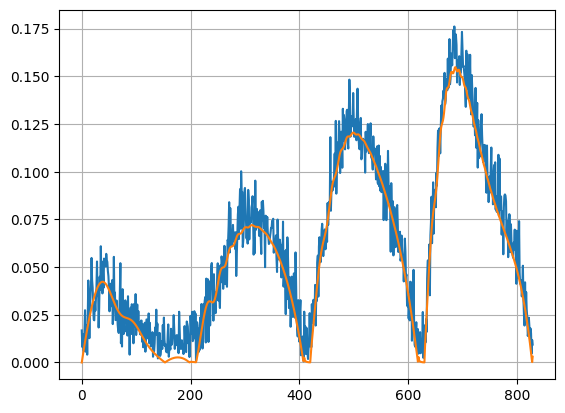

In [85]:

scale = np.linalg.norm(np.abs(signal),axis=1)
evol = np.abs(signal) / scale[:,None]

a_scale = np.abs(noisy_signal[0,:]) / np.linalg.norm(np.abs(noisy_signal[0,:]))
dot_a = np.dot(evol, a_scale) 
idx_a = np.argmax(dot_a) 
print(T1dict[idx_a])
print(T2dict[idx_a])

b_scale = noisy_signal[1,:] / np.linalg.norm(noisy_signal[1,:])
dot_b = np.dot(evol, np.abs(b_scale))
idx_b = np.argmax(dot_b) 
print(T1dict[idx_b])
print(T2dict[idx_b])

plt.figure()
plt.plot(np.abs(noisy_signal[0,:]))
plt.plot(np.abs(signal[idx_a,:]))
plt.grid()
plt.show()

plt.figure()
plt.plot(np.abs(noisy_signal[1,:]))
plt.plot(np.abs(signal[idx_b,:]))
plt.grid()
plt.show()



### Real-World MRF Data

A single radial k-space spoke was acquired in each frame of a 512-point MRF acquisition on a 0.35T scanner. The flip angle pattern, basis functions, and raw data from a single RF coil are shown below.

(1, 512, 256, 2)


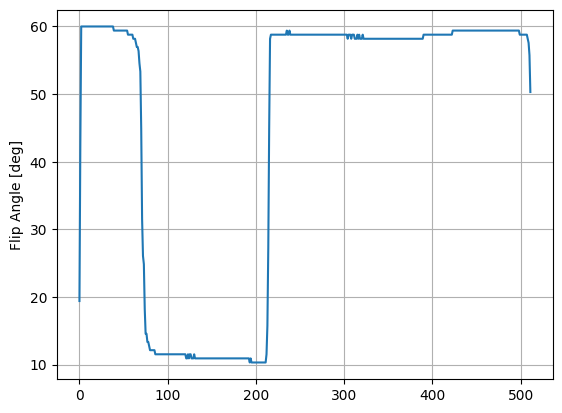

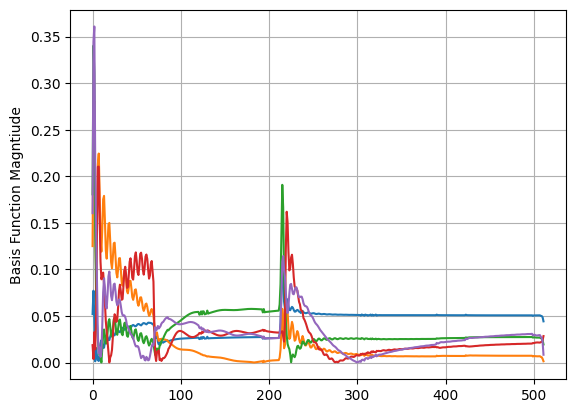

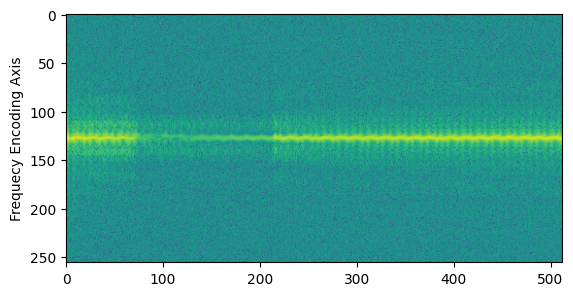

In [16]:
R = 5
df = sio.loadmat('dictionary.mat')
evol = df['evol']
lut = df['lut']
basis = df['U'][:,:R]

df = sio.loadmat('data_nist_ismrm_phantom_slc23_R1.mat')
data = df['data']
caipi = df['phi']

df = sio.loadmat('flipAnglePatternDegrees.mat')
flipAngleDeg = df['flipAngleDeg'][0,:]

df = sio.loadmat('data_nist_ismrm_phantom_traj.mat')
traj = df['traj']
dcf = df['dcf']


plt.figure()
plt.plot(flipAngleDeg)
plt.grid()
plt.ylabel('Flip Angle [deg]')
plt.show()

plt.figure()
plt.plot(np.abs(basis))
plt.grid()
plt.ylabel('Basis Function Magntiude')
plt.show()

plt.figure()
plt.imshow(np.log10(np.abs(data[:,0,:,0])))
plt.ylabel('Frequecy Encoding Axis')
plt.show()


### Low-Rank MRF Reconstruction

With only a single line through k-space being available at each point in the MRF train, a frame-by-frame inverse FFT is not feasible. It would only produce a wave across the FOV without resolving any anatomy along the direction orthogonal to the radial k-space spoke. 

Instead, we will reconstruct the entire time series all at once by constraining the image to span the basis set shown above. 

While the final goal is to recover a 128x128 image at all 512 frames, we will reconstruct 5 128x128 images corresponding to the coefficients of the each of the 5 basis functions. 

Let $\alpha$ be these 5 images. We will reconstruct $\alpha$ by minimizing the following cost function: 

$|| \mathbf{F}\mathbf{\Phi}\mathbf{S}\alpha - y||_2^2$

Here, $y$ are the measured k-space points for each MRF frame and each coil, $\mathbf{S}$ are the sensitivity maps for each RF coil channel, $\mathbf{\Phi}$ is a 512x5 matrix containing the basis functions, and $\mathbf{F}$ is the non-uniform Fourier transform that brings each image frame to the radial k-space. This is a linear problem that can be solved with conjugate gradients. 

/home/nikolai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


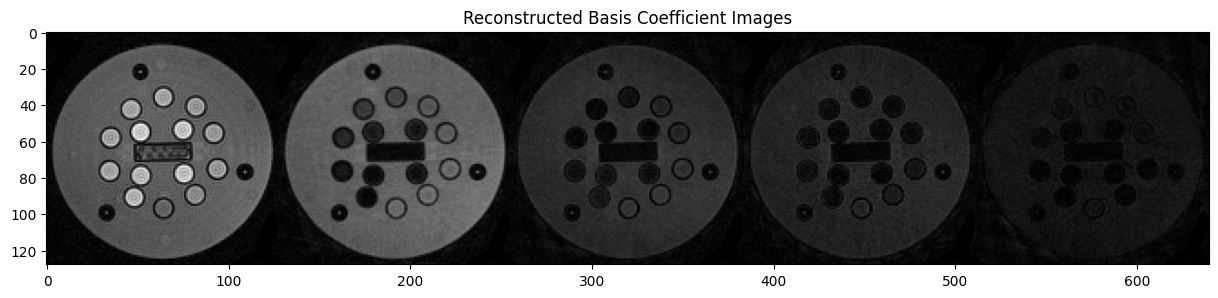

In [24]:
dataFile = 'data_nist_ismrm_phantom_slc23_R1.mat'
trajFile = 'data_nist_ismrm_phantom_traj.mat' 
basisFile = 'basis.mat'
outFile = 'recon_output.mat' 

numIterationsADMM = 1
numIterationsCG = 20
admmRho = 0
llrLambda = 0
llrWin = 8
useGpuFlag = 1

comm = 'python3 processMrfData.py %s %s %s %i %i %f %f %i %i %s'%(dataFile, trajFile, basisFile, numIterationsADMM, numIterationsCG, admmRho, llrLambda, llrWin, useGpuFlag, outFile)
os.system(comm)

df = sio.loadmat(outFile) 
recon = df['recon']

img = np.concatenate([recon[:,:,n,0] for n in range(recon.shape[2])], axis=-1)
fig = plt.figure()
fig.set_figwidth(15.0)
plt.imshow(np.abs(img), cmap='gray')
plt.title('Reconstructed Basis Coefficient Images')
plt.show() 


### Dictionary Matching

100%|██████████| 128/128 [00:01<00:00, 64.74it/s]


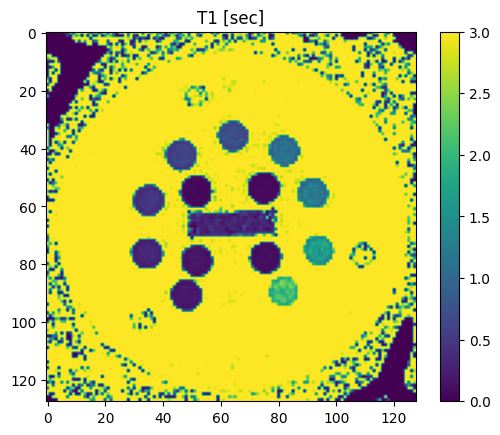

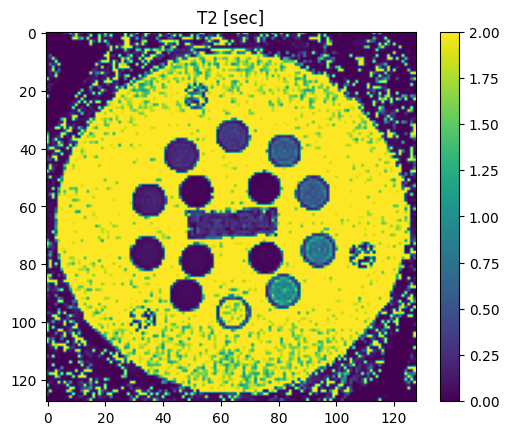

In [39]:
df = sio.loadmat(basisFile)
basis = df['basis']

dictFile = 'dictionary.mat'
df = sio.loadmat(dictFile)
evol = df['evol']
lut = df['lut']

# get low-rank representation of every signal evolution in dictionary 
elr = np.conj(basis.T) @ evol 
nrm = np.linalg.norm(elr, axis=0)
elr = elr / nrm[None,:]

T1_mrf = np.zeros((recon.shape[0], recon.shape[1]), dtype=np.float32) 
T2_mrf = np.zeros_like(T1_mrf) 
for r in tqdm(range(recon.shape[0])):
    for c in range(recon.shape[1]): 
        y = recon[r,c,:,0]
        nrmy = np.linalg.norm(y)
        if nrmy > 0:
            y = y / np.linalg.norm(y) 
            dp = elr.T@y # calculate the dot product 
            idx = np.argmax(np.abs(dp))
            T1_mrf[r,c] = lut[idx,0]
            T2_mrf[r,c] = lut[idx,1]

plt.figure()
plt.imshow(T1_mrf, vmin=0.0, vmax=3.0)
plt.title('T1 [sec]')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(T2_mrf, vmin=0.0, vmax=2.0)
plt.title('T2 [sec]')
plt.colorbar()
plt.show()